In [4]:
import pickle

# Load the assembled_dfs DataFrame from the pickle file
with open("assembled_dfs.pkl", "rb") as f:
    assembled_dfs = pickle.load(f)

# Display the first few rows to confirm the data was loaded correctly
print(assembled_dfs.head())


     daytime  Codi_barri  year  month  energy_amount  temp   area_m2  \
0  afternoon           1  2022      1        26318.0  10.2  65.97619   
1  afternoon           1  2022      2        22217.6  11.8  65.97619   
2  afternoon           1  2022      3        21687.3  10.8  65.97619   
3  afternoon           1  2022      4        19270.0  14.1  65.97619   
4  afternoon           1  2022      5        17786.0  20.7  65.97619   

          age  population  
0  113.304762      2215.2  
1  113.304762      2215.2  
2  113.304762      2215.2  
3  113.304762      2215.2  
4  113.304762      2215.2  


In [5]:
assembled_dfs.shape

(4488, 9)

In [6]:
assembled_dfs.dtypes

daytime           object
Codi_barri         int32
year               int32
month              int32
energy_amount    float64
temp             float64
area_m2          float64
age              float64
population       float64
dtype: object

In [7]:
# Establishing baseline model
X = assembled_dfs.drop(columns=['energy_amount', 'daytime'])
y = assembled_dfs['energy_amount']

In [8]:
# Performing the test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

In [9]:
# Performing xgb in a non engineered data
import xgboost as xgb

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_reg.score(X_test, y_test)

0.5291155299988046

In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_pred = xgb_reg.predict(X_test)

print("mse: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("mae: ", mean_absolute_error(y_test, y_pred))

mse:  11523.405062105427
mae:  8956.139206025095


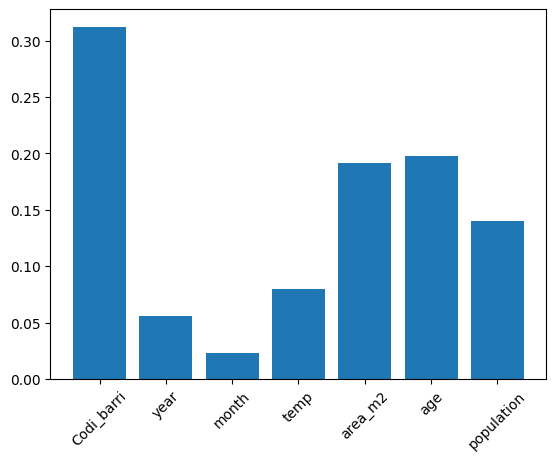

In [11]:
# Check the correlation between features and target
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.bar(range(len(xgb_reg.feature_importances_)), xgb_reg.feature_importances_)
plt.xticks(range(7), X.columns, rotation=45)
plt.show()

In [12]:
# Putting back all features to perform target encoding
X = assembled_dfs.drop(columns=['energy_amount'])
y = assembled_dfs['energy_amount']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

In [13]:
X_train['energy_amount'] = y_train
X_train.head()

,daytime,Codi_barri,year,month,temp,area_m2,age,population,energy_amount
2284,morning,2,2022,8,27.2,88.677778,123.855556,2527.6,25233.9
4193,night,48,2022,3,10.8,75.172727,51.472727,1368.7,19147.5
1406,evening,11,2023,9,23.2,65.996774,74.680645,1589.6,72779.2
3878,night,26,2023,6,23.4,128.016129,63.567742,1537.9,34771.9
103,afternoon,5,2022,5,20.7,81.590000,63.095000,1672.2,57626.1


In [14]:
codi_avg_energy_dict = (
    X_train.groupby('Codi_barri')[['energy_amount']]
    .mean()
    .squeeze() 
    .to_dict()
)

# Save dictionaries as pickle files
with open('codi_avg_energy_dict.pkl', 'wb') as file:
    pickle.dump(codi_avg_energy_dict, file)

codi_avg_energy_dict




{1: 17215.18380952381,
 2: 26278.53370786517,
 3: 37928.94742268041,
 5: 59498.951515151515,
 6: 13259.477777777778,
 7: 17877.378723404257,
 8: 26297.660416666666,
 9: 51008.509523809524,
 11: 36975.62527472527,
 12: 22223.042391304345,
 15: 53978.806,
 17: 62407.022000000004,
 21: 39819.407843137255,
 22: 38460.13695652174,
 25: 26724.14347826087,
 26: 40256.114285714284,
 27: 33451.76296296296,
 30: 49170.93529411765,
 31: 28513.503092783503,
 32: 46624.591262135924,
 35: 33741.468686868684,
 36: 36870.30190476191,
 38: 21722.959,
 42: 28816.02886597938,
 45: 39164.51098901099,
 48: 26464.703921568627,
 53: 15864.36213592233,
 58: 53493.155,
 61: 43604.984112149534,
 64: 25835.47692307692,
 65: 50201.4206185567,
 66: 38362.19793814433,
 69: 34191.25588235294,
 72: 40399.51022727272}

In [15]:
X_train['codi_avg_energy'] = X_train['Codi_barri'].replace(codi_avg_energy_dict)
X_train.head()

,daytime,Codi_barri,year,month,temp,area_m2,age,population,energy_amount,codi_avg_energy
2284,morning,2,2022,8,27.2,88.677778,123.855556,2527.6,25233.9,26278.533708
4193,night,48,2022,3,10.8,75.172727,51.472727,1368.7,19147.5,26464.703922
1406,evening,11,2023,9,23.2,65.996774,74.680645,1589.6,72779.2,36975.625275
3878,night,26,2023,6,23.4,128.016129,63.567742,1537.9,34771.9,40256.114286
103,afternoon,5,2022,5,20.7,81.590000,63.095000,1672.2,57626.1,59498.951515


In [16]:
X_train['energy/person'] = X_train['energy_amount']/X_train['population']
X_train.head()

,daytime,Codi_barri,year,month,temp,area_m2,age,population,energy_amount,codi_avg_energy,energy/person
2284,morning,2,2022,8,27.2,88.677778,123.855556,2527.6,25233.9,26278.533708,9.983344
4193,night,48,2022,3,10.8,75.172727,51.472727,1368.7,19147.5,26464.703922,13.989552
1406,evening,11,2023,9,23.2,65.996774,74.680645,1589.6,72779.2,36975.625275,45.784600
3878,night,26,2023,6,23.4,128.016129,63.567742,1537.9,34771.9,40256.114286,22.609988
103,afternoon,5,2022,5,20.7,81.590000,63.095000,1672.2,57626.1,59498.951515,34.461249


In [17]:
codi_avg_energyperperson_dict = (
    X_train.groupby('Codi_barri')[['energy/person']]
    .mean()
    .squeeze() 
    .to_dict()
)

with open('codi_avg_energyperperson_dict.pkl', 'wb') as file:
    pickle.dump(codi_avg_energyperperson_dict, file)

In [18]:
codi_avg_energyperperson_dict

{1: 7.807558738844169,
 2: 9.706302773875196,
 3: 24.84724386345051,
 5: 34.334812325217555,
 6: 8.689082227199941,
 7: 11.70346489466026,
 8: 15.915828444002019,
 9: 33.99833391114938,
 11: 23.160244369659374,
 12: 12.39685270224497,
 15: 34.81112909050094,
 17: 42.70065595246595,
 21: 25.310150094650187,
 22: 24.635837564299916,
 25: 18.44648797942246,
 26: 26.182602411258994,
 27: 21.633328566702524,
 30: 36.51720808785987,
 31: 20.443913250476417,
 32: 33.58644985390122,
 35: 22.49277973025801,
 36: 25.373026157278066,
 38: 15.132384749159337,
 42: 19.788501463834848,
 45: 26.609801876722667,
 48: 19.1568316804671,
 53: 9.063419472792754,
 58: 34.16862536972057,
 61: 27.530576086033562,
 64: 16.7737508156622,
 65: 32.207067366395876,
 66: 21.75885399277487,
 69: 17.545836699809747,
 72: 28.432115092756966}

In [19]:
X_train['energy/person'] = X_train['Codi_barri'].replace(codi_avg_energyperperson_dict)
X_train.head()

,daytime,Codi_barri,year,month,temp,area_m2,age,population,energy_amount,codi_avg_energy,energy/person
2284,morning,2,2022,8,27.2,88.677778,123.855556,2527.6,25233.9,26278.533708,9.706303
4193,night,48,2022,3,10.8,75.172727,51.472727,1368.7,19147.5,26464.703922,19.156832
1406,evening,11,2023,9,23.2,65.996774,74.680645,1589.6,72779.2,36975.625275,23.160244
3878,night,26,2023,6,23.4,128.016129,63.567742,1537.9,34771.9,40256.114286,26.182602
103,afternoon,5,2022,5,20.7,81.590000,63.095000,1672.2,57626.1,59498.951515,34.334812


In [21]:
# Calculate the mean of energy_amount for daytime, month, and Codi_barri
daytime_month_avg_energy_dict = (
    X_train.groupby(['daytime', 'month'])['energy_amount']
    .mean()
    .to_dict()
)

with open('daytime_month_avg_energy_dict.pkl', 'wb') as file:
    pickle.dump(daytime_month_avg_energy_dict, file)

# Map the combined average back to the DataFrame
X_train['daytime_month_avg_energy'] = X_train.set_index(
    ['daytime', 'month']
).index.map(daytime_month_avg_energy_dict)

# Drop columns that are not part of the engineered features
X_train_engineered = X_train.drop(['daytime', 'month', 'year', 'Codi_barri', 'energy_amount'], axis=1)
X_train_original = X_train[['daytime', 'month', 'Codi_barri']]

In [22]:
X_train_engineered.head()

,temp,area_m2,age,population,codi_avg_energy,energy/person,daytime_month_avg_energy
2284,27.2,88.677778,123.855556,2527.6,26278.533708,9.706303,34639.319231
4193,10.8,75.172727,51.472727,1368.7,26464.703922,19.156832,21502.850575
1406,23.2,65.996774,74.680645,1589.6,36975.625275,23.160244,40368.871053
3878,23.4,128.016129,63.567742,1537.9,40256.114286,26.182602,23834.354321
103,20.7,81.590000,63.095000,1672.2,59498.951515,34.334812,32505.475641


In [23]:
xgb_reg = xgb.XGBRegressor()

# Use the engineered features for training
xgb_reg.fit(X_train_engineered, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
# Replace Codi_barri with energy/person using the dictionary
X_test['energy/person'] = X_test['Codi_barri'].replace(codi_avg_energyperperson_dict)

# Replace daytime, month, and Codi_barri with their combined average
X_test['daytime_month_avg_energy'] = (
    X_test[['daytime', 'month']]
    .apply(tuple, axis=1)
    .map(daytime_month_avg_energy_dict)
)

# Replace Codi_barri with the average energy_amount using the dictionary
X_test['codi_avg_energy'] = X_test['Codi_barri'].replace(codi_avg_energy_dict)

# Drop unused columns from test data
X_test_engineered = X_test.drop(['daytime', 'Codi_barri', 'year', 'month'], axis=1)

# Ensure the columns match the training data
X_test_engineered = X_test_engineered[X_train_engineered.columns]

# Make predictions
predictions = xgb_reg.predict(X_test_engineered)

# Combine predictions with original metadata for interpretability
X_test['predicted_energy'] = predictions



In [25]:
X_test_engineered.head()

,temp,area_m2,age,population,codi_avg_energy,energy/person,daytime_month_avg_energy
157,13.0,75.291176,65.491176,1553.7,13259.477778,8.689082,36580.419737
4246,14.8,60.605263,51.989474,1743.5,15864.362136,9.063419,22436.237255
1020,26.2,74.076471,58.352941,1574.5,50201.420619,32.207067,48537.640278
1119,26.2,75.074359,53.171795,1459.5,40399.510227,28.432115,48537.640278
731,24.7,68.734615,49.876923,1417.3,21722.959000,15.132385,42587.804167


In [26]:
xgb_reg.score(X_test_engineered, y_test)

0.9680681682886058

In [401]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state =1)

model = model.fit(X_train_engineered, y_train)

model.score(X_test_engineered, y_test)


0.8627754296806927

In [402]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
	n_estimators = 20, 
	max_depth = 3,
	random_state =1
)

model = model.fit(X_train_engineered,  y_train)
model.score(X_test_engineered, y_test)


0.7504561807687976

In [403]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the model
model = GradientBoostingRegressor(
    max_depth=5, 
    n_estimators=100,
    random_state=1
)

# Fit the model
model = model.fit(X_train_engineered, y_train)

# Evaluate the model
score = model.score(X_test_engineered, y_test)
print(score)




0.9416911882469493


In [404]:
train_score = xgb_reg.score(X_train_engineered, y_train)
test_score = xgb_reg.score(X_test_engineered, y_test)

print(f"Train R^2: {train_score}")
print(f"Test R^2: {test_score}")

Train R^2: 0.9963951241081318
Test R^2: 0.9680681682886058


In [405]:
# Initialize the model
model = GradientBoostingRegressor(
    max_depth=5, 
    n_estimators=100,
    random_state=1
)

# Fit the model
model = model.fit(X_train_engineered, y_train)

# Evaluate the model
train_score = model.score(X_train_engineered, y_train)
test_score = model.score(X_test_engineered, y_test)

print(f"Train R^2: {train_score}")
print(f"Test R^2: {test_score}")

Train R^2: 0.970194763180981
Test R^2: 0.9416911882469493


In [406]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train_engineered, y_train, cv=5, scoring='r2')
print(f"Cross-Validation R^2 Scores: {cv_scores}")
print(f"Mean CV R^2: {cv_scores.mean()}")


Cross-Validation R^2 Scores: [0.9417436  0.94432075 0.95602162 0.94020036 0.96074147]
Mean CV R^2: 0.9486055605313976


In [407]:
# Initialize the model
xgb_reg = xgb.XGBRegressor(
    max_depth=5,
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)

# Perform cross-validation
cv_scores = cross_val_score(xgb_reg, X_train_engineered, y_train, cv=5, scoring='r2')

# Print the results
print(f"Cross-Validation R^2 Scores: {cv_scores}")
print(f"Mean CV R^2: {cv_scores.mean()}")

Cross-Validation R^2 Scores: [0.95531069 0.9534598  0.96330657 0.95070363 0.9674478 ]
Mean CV R^2: 0.9580456975779349


In [408]:


xgb_reg = xgb.XGBRegressor(
    max_depth=5,
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)

# Fit the model on training data
xgb_reg.fit(X_train_engineered, y_train)

# Make predictions
y_pred = xgb_reg.predict(X_test_engineered)

# Compute metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("mse: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("mae: ", mean_absolute_error(y_test, y_pred))

mse:  3578.046039233916
mae:  2266.415951826398


In [409]:
# Pickle the relevant objects
xgb_reg.fit(X_train_engineered, y_train)


with open('pickled_model.pkl', 'wb') as file:
    pickle.dump(xgb_reg, file)

In [410]:
# Pickle dictionaries
pickle.dump(codi_avg_energyperperson_dict, open('codi_avg_energyperperson_dict.pkl', 'wb'))
pickle.dump(daytime_month_avg_energy_dict, open('daytime_month_avg_energy_dict', 'wb'))
pickle.dump(codi_avg_energy_dict, open('codi_avg_energy_dict', 'wb'))

In [31]:
from sklearn.model_selection import cross_val_predict
import pandas as pd

# Perform cross-validation and get predictions
y_pred_cv = cross_val_predict(xgb_reg, X_train_engineered, y_train, cv=5)

# Create a DataFrame to compare actual vs. predicted
results_df = pd.DataFrame({
    'Actual': y_train,
    'Predicted': y_pred_cv
})

# Print a sample of the results
print(results_df.tail(20))  # Show first 20 rows for comparison

# Save to CSV for further inspection if needed
results_df.to_csv('cross_validation_results.csv', index=False)

       Actual     Predicted
2558  20782.3  20536.849609
1082  26204.0  25148.378906
474   39240.0  38077.382812
2904  42900.5  43518.714844
4117   9479.9  10158.474609
3385  17343.9  16665.859375
1184  29966.8  32391.890625
2433  19081.0  17588.355469
2391  11827.3  11597.013672
769   32304.4  31874.695312
1685  70298.1  65567.617188
130   71440.7  62908.867188
2919  27166.4  29095.841797
3171  40798.1  39259.878906
3444  29775.9  29023.423828
4426  25908.3  24276.154297
466   33128.5  35078.851562
3092  26550.0  30086.896484
3772  25612.8  24488.599609
860   19164.4  18411.306641


In [414]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime

# Load dictionaries
with open('codi_avg_energy_dict.pkl', 'rb') as file:
    codi_avg_energy_dict = pickle.load(file)

with open('codi_avg_energyperperson_dict.pkl', 'rb') as file:
    codi_avg_energyperperson_dict = pickle.load(file)

with open('daytime_month_avg_energy_dict.pkl', 'rb') as file:
    daytime_month_avg_energy_dict = pickle.load(file)

# Load assembled_dfs for historical data
with open("assembled_dfs.pkl", "rb") as f:
    assembled_dfs = pickle.load(f)

# Generate synthetic data
start_date = datetime(2024, 11, 1)
end_date = datetime(2026, 12, 1)

# Generate all months between start_date and end_date
date_range = pd.date_range(start_date, end_date, freq='MS')
years = date_range.year
months = date_range.month

# Define values for daytime and Codi_barri
daytimes = ['morning', 'afternoon', 'evening', 'night']
codi_barris = [1, 2, 3, 5, 6, 7, 8, 9, 11, 12, 15, 17, 21, 22, 25, 26, 27, 30, 31, 32, 
               35, 36, 38, 42, 45, 48, 53, 58, 61, 64, 65, 66, 69, 72]

# Calculate temperature trends based on historical data
historical_temps = assembled_dfs.groupby(['year', 'month'])['temp'].mean().reset_index()
temp_trend = historical_temps.groupby('month')['temp'].mean().to_dict()  # Monthly average over years

# Initialize synthetic data list
synthetic_data = []
index = 4489

# Generate synthetic data
for year, month in zip(years, months):
    for daytime in daytimes:
        for codi_barri in codi_barris:
            area_m2_mean = assembled_dfs[assembled_dfs['Codi_barri'] == codi_barri]['area_m2'].mean()
            age_mean = assembled_dfs[assembled_dfs['Codi_barri'] == codi_barri]['age'].mean()
            population_mean = assembled_dfs[assembled_dfs['Codi_barri'] == codi_barri]['population'].mean()

            synthetic_data.append({
                'Index': index,
                'daytime': daytime,
                'Codi_barri': codi_barri,
                'year': year,
                'month': month,
                'temp': temp_trend.get(month, np.nan),  # Use mapped temperature trend
                'area_m2': area_m2_mean if not np.isnan(area_m2_mean) else 0,
                'age': age_mean + (year - 2024) if not np.isnan(age_mean) else 0,
                'population': population_mean * 1.01 if not np.isnan(population_mean) else 0,
                'codi_avg_energy': codi_avg_energy_dict.get(codi_barri, 0),
                'energy/person': codi_avg_energyperperson_dict.get(codi_barri, 0),
                'daytime_month_avg_energy': daytime_month_avg_energy_dict.get((daytime, month), 0),
            })
            index += 1

# Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Save synthetic data as a pickle file
with open('synthetic_data.pkl', 'wb') as f:
    pickle.dump(synthetic_df, f)

print("Synthetic data generated and saved as 'synthetic_data.pkl'.")



Synthetic data generated and saved as 'synthetic_data.pkl'.


In [416]:
print(type(synthetic_df))

<class 'pandas.core.frame.DataFrame'>


In [377]:
HOOD_MAPPING = {
    "el Raval": 1,
    "el Barri Gòtic": 2,
    "la Barceloneta": 3,
    "Sant Pere, Santa Caterina i la Ribera": 3,
    "el Fort Pienc": 5,
    "la Sagrada Família": 6,
    "la Dreta de l'Eixample": 7,
    "l'Antiga Esquerra de l'Eixample": 8,
    "la Nova Esquerra de l'Eixample": 9,
    "Sant Antoni": 9,
    "el Poble Sec": 11,
    "la Marina del Prat Vermell": 12,
    "la Marina de Port": 12,
    "la Font de la Guatlla": 11,
    "Hostafrancs": 15,
    "la Bordeta": 15,
    "Sants-Badal": 17,
    "Sants": 17,
    "les Corts": 17,
    "la Maternitat i Sant Ramon": 17,
    "Pedralbes": 21,
    "Vallvidrera, el Tibidabo i les Planes": 22,
    "Sarrià": 22,
    "les Tres Torres": 21,
    "Sant Gervasi - la Bonanova": 25,
    "Sant Gervasi - Galvany": 26,
    "el Putxet i el Farró": 27,
    "Vallcarca i els Penitents": 27,
    "el Coll": 27,
    "la Salut": 30,
    "la Vila de Gràcia": 31,
    "Vila de Gràcia": 31,
    "el Camp d'en Grassot i Gràcia Nova": 32,
    "el Baix Guinardó": 32,
    "Can Baró": 30,
    "el Guinardó": 35,
    "la Font d'en Fargues": 36,
    "el Carmel": 36,
    "la Teixonera": 38,
    "Sant Genís dels Agudells": 38,
    "Montbau": 38,
    "la Vall d'Hebron": 38,
    "la Clota": 42,
    "Horta": 42,
    "Vilapicina i la Torre Llobeta": 42,
    "Porta": 45,
    "el Turó de la Peira": 42,
    "Can Peguera": 42,
    "la Guineueta": 48,
    "Canyelles": 38,
    "les Roquetes": 42,
    "Verdun": 42,
    "la Prosperitat": 45,
    "la Trinitat Nova": 53,
    "Torre Baró": 53,
    "Ciutat Meridiana": 53,
    "Vallbona": 53,
    "la Trinitat Vella": 53,
    "Baró de Viver": 58,
    "el Bon Pastor": 58,
    "Sant Andreu": 58,
    "la Sagrera": 61,
    "el Congrés i els Indians": 61,
    "Navas": 61,
    "el Camp de l'Arpa del Clot": 64,
    "Camp de l'Arpa del Clot": 64,
    "el Clot": 65,
    "el Parc i la Llacuna del Poblenou": 66,
    "la Vila Olímpica del Poblenou": 66,
    "el Poblenou": 66,
    "Diagonal Mar i el Front Marítim del Poblenou": 69,
    "el Besòs i el Maresme": 69,
    "Provençals del Poblenou": 69,
    "Sant Martí de Provençals": 72,
    "la Verneda i la Pau": 72,
}

pickle.dump(HOOD_MAPPING, open('HOOD_MAPPING.pkl', 'wb'))

In [417]:
synthetic_df

,Index,daytime,Codi_barri,year,month,temp,area_m2,age,population,codi_avg_energy,energy/person,daytime_month_avg_energy
0,4489,morning,1,2024,11,15.00,65.850216,113.733333,2227.968182,17215.183810,7.807559,33495.076000
1,4490,morning,2,2024,11,15.00,88.680808,123.582828,2759.659727,26278.533708,9.706303,33495.076000
2,4491,morning,3,2024,11,15.00,60.963636,98.304545,1542.912727,37928.947423,24.847244,33495.076000
3,4492,morning,5,2024,11,15.00,81.605000,63.805909,1743.406909,59498.951515,34.334812,33495.076000
4,4493,morning,6,2024,11,15.00,75.298663,64.504011,1541.801727,13259.477778,8.689082,33495.076000
...,...,...,...,...,...,...,...,...,...,...,...,...
3531,8020,night,64,2026,12,12.35,70.579636,65.106545,1554.959273,25835.476923,16.773751,25308.010417
3532,8021,night,65,2026,12,12.35,74.125668,59.495187,1575.517364,50201.420619,32.207067,25308.010417
3533,8022,night,66,2026,12,12.35,77.470588,58.378877,1783.072364,38362.197938,21.758854,25308.010417
3534,8023,night,69,2026,12,12.35,73.610227,47.569886,1980.610000,34191.255882,17.545837,25308.010417
